# **Wikipedia Racing Agent**

Along with the growth of Wikipedia came Wiki Racing, a game in which players try to get from one page to another as fast as possible. In today's Wikirace example, the goal is to get from Virus to European Commission, which may include a path from Virus to Dmitri Ivanovsky to Poland and so on.

This notebook demonstrates the integration between Judgment Labs and Fireworks AI RFT through creating a multi-turn Wikiracer agent.





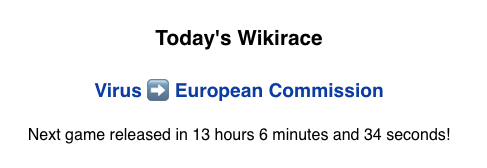

To run this notebook and train a WikiRacer Agent, select **Runtime* -> Run All*

In [ ]:
# Installations
!pip install wikipedia requests openai python-dotenv judgeval
!pip install --upgrade fireworks-ai


Go to https://docs.judgmentlabs.ai/documentation and follow the instructions to get a

```
JUDGMENT API_KEY, JUDGMENT_ORG_ID
```



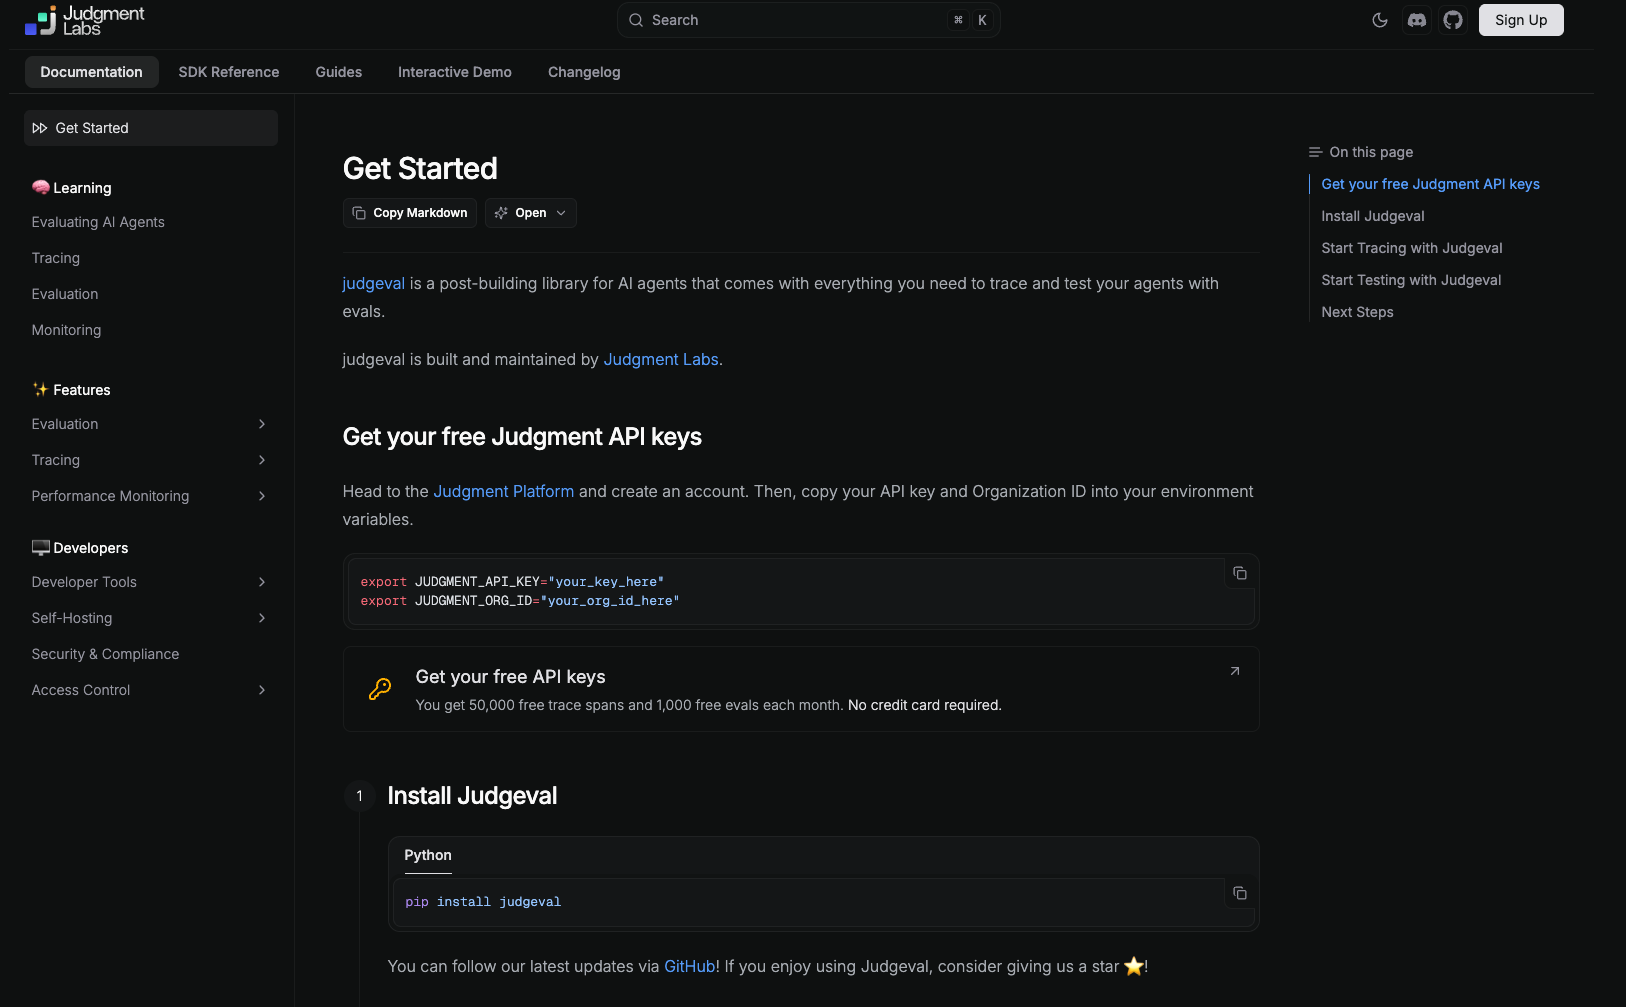

You will also need a Fireworks [account](https://fireworks.ai/models/fireworks/gpt-oss-120b?utm_term=try%20gpt%20oss&utm_campaign=Model+Ads&utm_source=adwords&utm_medium=ppc&hsa_acc=6824341280&hsa_cam=22178032006&hsa_grp=184596082952&hsa_ad=769836452118&hsa_src=g&hsa_tgt=kwd-2435895313574&hsa_kw=try%20gpt%20oss&hsa_mt=b&hsa_net=adwords&hsa_ver=3&gad_source=1&gad_campaignid=22178032006&gbraid=0AAAAA-vkpDMNFYpW82VA1cwxkZqpL6xBA&gclid=Cj0KCQjwuKnGBhD5ARIsAD19RsZlJ6gcEhusZsBx4nmkjZzFqXPbS16c1ZX8kaGqVU6DXQ_jBd3U5AwaAsWCEALw_wcB)

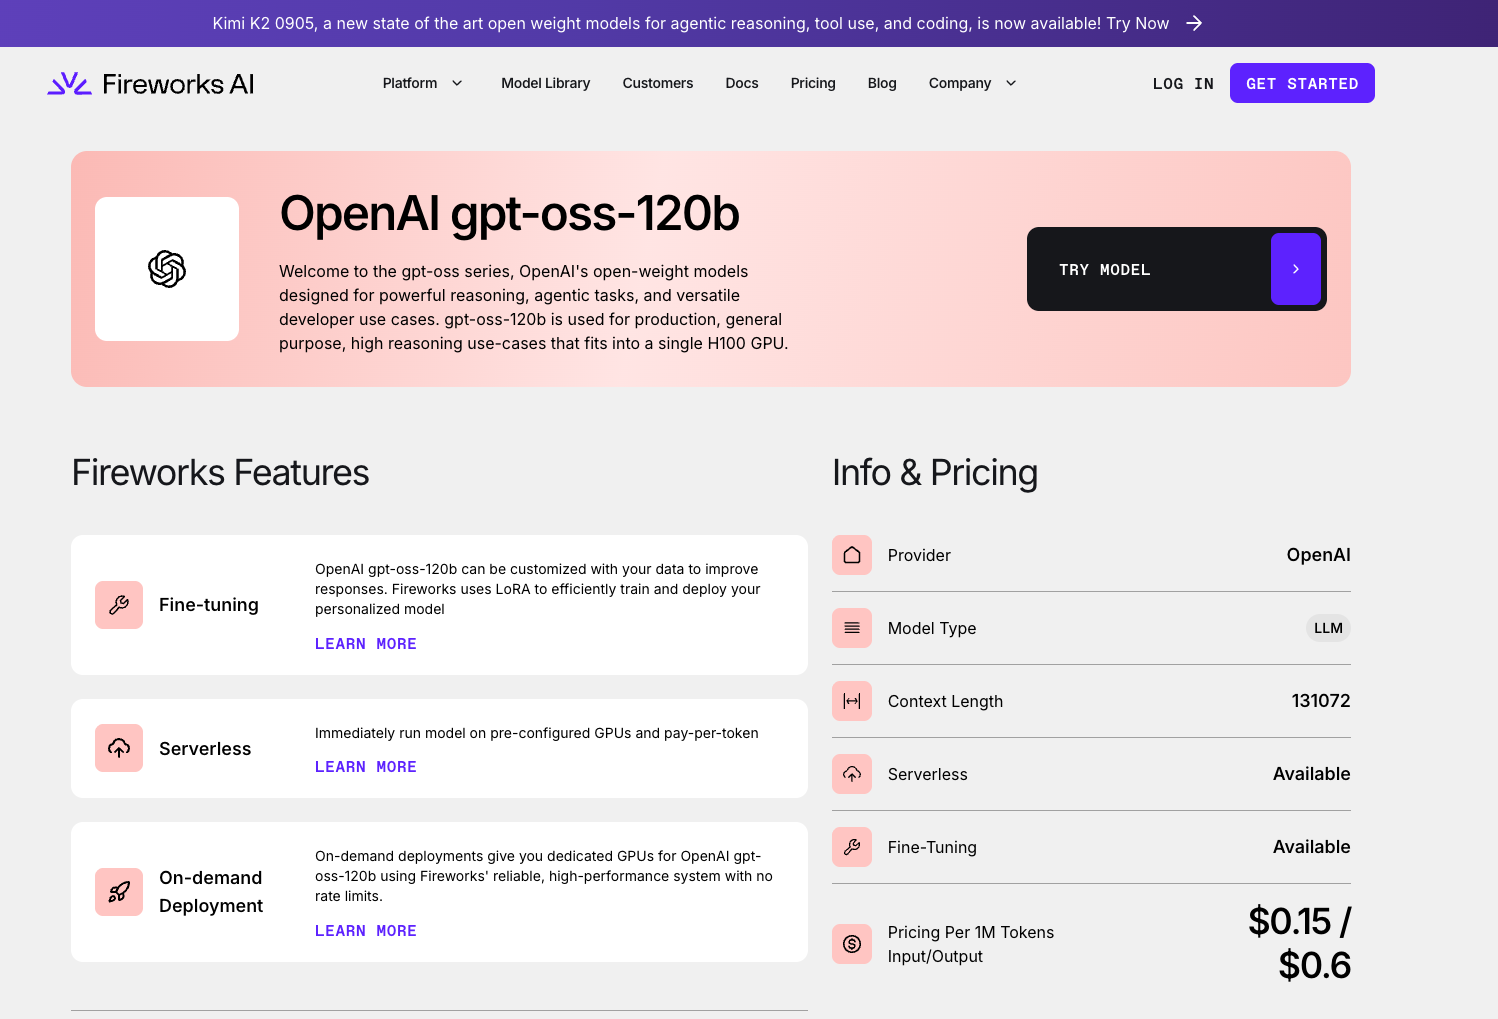

In [ ]:
# set api keys
import os
from dotenv import load_dotenv

os.environ['OPENAI_API_KEY'] =
os.environ["JUDGMENT_API_KEY"] =
os.environ["JUDGMENT_ORG_ID"] =
os.environ["FIREWORKS_API_KEY"] =

load_dotenv()

False

In [ ]:
from judgeval.data import Example
import requests
import openai
import os
import json
import random
from dotenv import load_dotenv
from judgeval.trainer import JudgmentTrainer, TrainerConfig
from judgeval.tracer import Tracer, wrap
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.trainer.trainable_model import TrainableModel


Here, we use the wikipedia python library to access link choosing and following.


In [ ]:
# wikipedia helper functions
def get_wikipedia_links(page_title: str) -> list:
    """Get all links from a Wikipedia page"""
    url = "https://en.wikipedia.org/w/api.php"

    headers = {
        'User-Agent': 'WikipediaRacingBot/1.0 (https://example.com/contact) requests/2.28.1'
    }

    params = {
        'action': 'query',
        'format': 'json',
        'titles': page_title,
        'prop': 'links',
        'pllimit': 'max'
    }

    try:
        response = requests.get(url, params=params, headers=headers)
        data = response.json()

        pages = data['query']['pages']
        page_id = list(pages.keys())[0]

        if page_id == '-1':
            return []

        links = pages[page_id].get('links', [])
        link_titles = [link['title'] for link in links]
        return link_titles

    except Exception as e:
        print(f"Error: {e}")
        return []

def filter_available_links(links, visited_pages, target_page=None):
    filtered = []

    for link in links:
        # Skip visited pages
        if link in visited_pages:
            continue

        # Skip meta/technical links
        skip_patterns = [
            'wikipedia:', 'category:', 'template:', 'file:', 'help:',
            '(disambiguation)', 'list of', 'timeline of', 'history of'
        ]
        if any(pattern in link.lower() for pattern in skip_patterns):
            continue

        # unlikely we want a specific event. It's easier to hardcode some of this out to keep the agent focused on broaded link clicks
        if any(year in link for year in ['1999', '2000', '2001', '2002', '2003', '2004', '2005']):
            continue

        if len(link.split()) > 4:
            continue

        filtered.append(link)

    if target_page:
        filtered = rank_links_by_relevance(filtered, target_page)
    else:
        # If no target, at least deprioritize numbered/address links
        filtered = deprioritize_bad_links(filtered)

    return filtered[:15]  # Return top 15

def rank_links_by_relevance(links, target_page):
    # rank by relevancy
    target_lower = target_page.lower()

    def relevance_score(link):
        link_lower = link.lower()
        score = 0

        # Exact match gets highest score
        if link_lower == target_lower:
            return 1000

        # Partial matches
        if target_lower in link_lower or link_lower in target_lower:
            score += 100

        # Geographic targets - prioritize location-related links
        if any(geo_term in target_lower for geo_term in ['california', 'mountain view', 'seattle', 'chicago']):
            if any(geo_word in link_lower for geo_word in ['city', 'county', 'state', 'california', 'united states', 'geography']):
                score += 50

        # Company targets - prioritize business-related links
        if any(biz_term in target_lower for biz_term in ['apple', 'google', 'microsoft', 'tesla']):
            if any(biz_word in link_lower for biz_word in ['company', 'corporation', 'inc.', 'technology', 'business']):
                score += 50

        # Heavily penalize numbered addresses and technical specs
        if link.split()[0].isdigit():
            score -= 200

        # Penalize very specific technical terms
        if any(tech in link_lower for tech in ['battery', 'protocol', 'specification']):
            score -= 100

        # Boost common conceptual links
        if any(concept in link_lower for concept in ['history', 'culture', 'economy', 'geography']):
            score += 20

        return score

    # Sort by relevance score (highest first)
    return sorted(links, key=relevance_score, reverse=True)

# bad links
def deprioritize_bad_links(links):
    good_links = []
    bad_links = []

    for link in links:
        # Check if it starts with numbers (addresses, technical specs)
        if link.split()[0].isdigit():
            bad_links.append(link)
        else:
            good_links.append(link)

    # Return good links first, then bad links
    return good_links + bad_links

Here, we'll create a small sample dataset of 4 easy examples, 4 medium examples, and 4 harder examples. Feel free to change both the quantity and content of these examples to match your interests and use case!

In [ ]:
# create a sample dataset
def create_small_wikipedia_dataset():
    """Create small focused dataset like 2048 (16 examples)"""

    small_dataset = [
        # Easy (2-3 hops) - Same domain connections
        {"start_page": "MacBook", "target_page": "Apple Inc.", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "iPhone", "target_page": "California", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Albert Einstein", "target_page": "Germany", "max_clicks": 4, "difficulty": "easy"},
        {"start_page": "Pizza", "target_page": "Italy", "max_clicks": 4, "difficulty": "easy"},

        # Medium (4-5 hops) - Cross category but logical
        {"start_page": "MacBook", "target_page": "California", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Google", "target_page": "Mountain View", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Tesla, Inc.", "target_page": "Elon Musk", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Microsoft", "target_page": "Seattle", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Albert Einstein", "target_page": "Physics", "max_clicks": 6, "difficulty": "medium"},
        {"start_page": "Barack Obama", "target_page": "Chicago", "max_clicks": 6, "difficulty": "medium"},

        # Hard (6+ hops) - Very different domains
        {"start_page": "MacBook", "target_page": "Pizza", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Albert Einstein", "target_page": "Basketball", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Google", "target_page": "Coffee", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Python (programming language)", "target_page": "Taylor Swift", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Quantum computing", "target_page": "McDonald's", "max_clicks": 8, "difficulty": "hard"},
        {"start_page": "Basketball", "target_page": "Philosophy", "max_clicks": 8, "difficulty": "hard"},
    ]

    return small_dataset

# Create the dataset
wikipedia_small_dataset = create_small_wikipedia_dataset()

# Convert to training prompts format
wikipedia_training_prompts = [
    {
        "start_page": ex["start_page"],
        "target_page": ex["target_page"],
        "max_clicks": ex["max_clicks"]
    }
    for ex in wikipedia_small_dataset
]

print(f"Created {len(wikipedia_training_prompts)} training examples")

Created 16 training examples


With the eventual goal of using RFT on this agent, we need a reward model. In this case, we define the following scorere which gives the agent points based on if it wins, uses fewer clicks, doesn't repeat or go in circles, and persists towards the task. Feel free to change these rewards as you see fit!

In [ ]:
# create a wikiracing scorer
class WikipediaRacingScorer(ExampleScorer):
    score_type: str = "WikipediaRacing"

    async def a_score_example(self, example: Example, *args, **kwargs) -> float:
        # Based on docs: agent results should be in actual_output
        actual_output = getattr(example, 'actual_output', None)
        input_data = getattr(example, 'input', {})

        print(f"Input: {input_data}")
        print(f"Actual output type: {type(actual_output)}")
        print(f"Actual output: {actual_output}")

        agent_results = None

        if isinstance(actual_output, dict):
            # Agent returned a dict directly
            agent_results = actual_output
            print("Found agent results in actual_output (dict)")
        elif isinstance(actual_output, str):
            # Agent might have returned a JSON string
            try:
                import json
                agent_results = json.loads(actual_output)
                print("Found agent results in actual_output (parsed JSON)")
            except:
                print("actual_output is string but not valid JSON")
                return 0.0
        else:
            print("actual_output is not dict or string")
            return 0.0

        # Extract game data from agent results
        if not isinstance(agent_results, dict):
            print(" Agent results is not a dict")
            return 0.0

        game_won = agent_results.get("game_won", False)
        clicks_used = agent_results.get("clicks_used", 0)
        path_history = agent_results.get("path_history", [])
        max_clicks = agent_results.get("max_clicks", 8)

        print(f" Extracted: Won={game_won}, Clicks={clicks_used}, Path length={len(path_history)}")
        print(f"Path: {' → '.join(path_history) if path_history else 'No path'}")

        # Full reward for winning
        if game_won:
            success_reward = 1.0
            efficiency_reward = max(0.1, 1.0 - (clicks_used - 1) / (max_clicks - 1) * 0.8)
            path_quality = len(set(path_history)) / len(path_history) if path_history else 0
            total_reward = success_reward + (efficiency_reward * 0.3) + (path_quality * 0.2)
            final_score = min(total_reward, 2.0) / 2.0
            print(f"  Full reward: {final_score}")
            return final_score

        # Partial credit for failed games
        partial_score = 0.0

        # Reward for making any progress
        if clicks_used > 0:
            partial_score += 0.15
            print(f"  +0.15 for making moves")

        # Reward for not going in circles
        if len(path_history) > 0:
            unique_ratio = len(set(path_history)) / len(path_history)
            circle_bonus = unique_ratio * 0.2
            partial_score += circle_bonus
            print(f"  +{circle_bonus:.3f} for avoiding circles ({unique_ratio:.2f} unique ratio)")

        # Reward for persistence
        if clicks_used >= 2:
            partial_score += 0.1
            print(f"  +0.1 for multiple moves")

        if clicks_used >= max_clicks - 1:
            partial_score += 0.05
            print(f"  +0.05 for persistence")

        final_partial = min(partial_score, 0.5)
        print(f"  Final partial reward: {final_partial}")
        return final_partial

See screenshot below for Fireworks Deployed Models UI. The model_id can be whatever name you specifcy, user_id will be your username upon signing up for an account, and deployment_id is shown above. In this case it is: lyha980l-v8-v1jsqktg

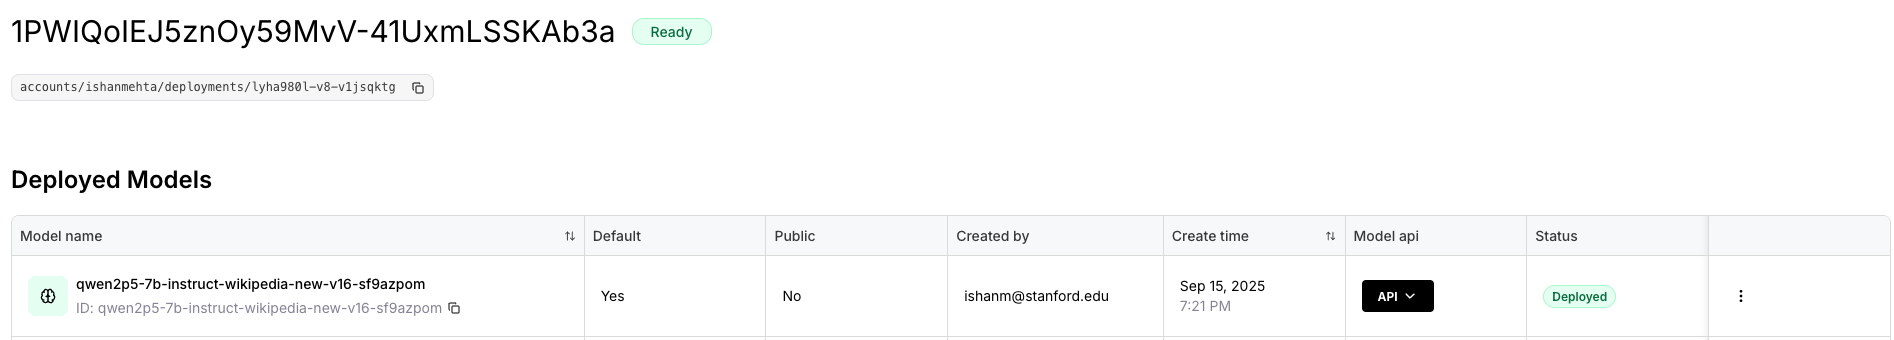

For more informatiom about Judgment Tracer, wrap, and Example Scorer, check out these documents.
https://docs.judgmentlabs.ai/documentation/tracing/introduction#tracing
https://docs.judgmentlabs.ai/documentation/evaluation/scorers/introduction

Now comes the Judgment Integration! We use the judgeval Trainer as well as the ExampleScorer class to set up the RFT job. Notice we how use the judgment.observe() decorator so we can monitor these functions in the UI

In [ ]:
# use judgment functions to wrap and trace model

from judgeval.trainer import JudgmentTrainer, TrainerConfig
from judgeval.tracer import Tracer, wrap
import os
from dotenv import load_dotenv
from judgeval.scorers.example_scorer import ExampleScorer
from judgeval.data import Example
from judgeval.trainer.trainable_model import TrainableModel
from judgeval.trainer.config import TrainerConfig
import re
import random

load_dotenv()


model = wrap(TrainableModel(
    TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",
        model_id="qwen2p5-7b-instruct-wikipedia-new",
        user_id="ishanmehta",
        deployment_id="lyha980l-v8-v1jsqktg"
    )
))

judgment = Tracer(
    project_name="wikipedia-racing-small",
    api_key=os.getenv("JUDGMENT_API_KEY")
)

# Create agent instance
agent_instance = WikipediaRacingAgent()

@judgment.observe(span_type="function")
async def get_model_response(messages: list) -> str:
    """Get a response from the model for the current conversation state."""
    response = await model.chat.completions.acreate(
        messages=messages,
        max_tokens=100,
        temperature=0.7,
        n=1,
    )
    return response.choices[0].message.content.strip()

@judgment.observe(span_type="function")
async def process_navigation_turn(messages: list, current_page: str, target_page: str,
                                available_links: list, click_count: int, max_clicks: int) -> tuple:
    """Process a single navigation turn."""

    # Create user prompt for this turn
    links_text = "\n".join([f"- {link}" for link in available_links[:15]])

    user_prompt = f"""Wikipedia Racing Navigation:

Current page: {current_page}
Target page: {target_page}
Clicks used: {click_count}/{max_clicks}

Available links from this page:
{links_text}

Choose ONE link that gets you closer to "{target_page}".
Respond with ONLY the exact link name from the list above."""

    # Add user message
    messages.append({"role": "user", "content": user_prompt})

    # Get model response
    assistant_response = await get_model_response(messages)

    # Add assistant response
    messages.append({"role": "assistant", "content": assistant_response})

    return messages, assistant_response

@judgment.observe(span_type="function")
async def wikipedia_racing_agent(start_page, target_page, max_clicks, **kwargs):
    """
    Wikipedia racing agent that navigates from start to target page. It returns a
    dict with game results and conversation history
    """

    # Initialize game state
    current_page = start_page
    path_history = [start_page]
    click_count = 0

    # Initialize conversation
    messages = [
        {
            "role": "system",
            "content": f"You are an expert Wikipedia navigator. Your goal is to get from '{start_page}' to '{target_page}' by clicking links. Choose links strategically to reach your target in the fewest clicks possible."
        }
    ]
    responses = []

    # Game loop
    while click_count < max_clicks:
        # Check win condition
        if _normalize_title(current_page) == _normalize_title(target_page):
            break

        # Get available links with relevance ranking
        raw_links = get_wikipedia_links(current_page)
        available_links = filter_available_links(raw_links, path_history, target_page)

        if not available_links:
            break

        # Get model's choice
        messages, assistant_response = await process_navigation_turn(
            messages, current_page, target_page, available_links,
            click_count, max_clicks
        )
        responses.append(assistant_response)

        # Parse and validate choice
        chosen_link = assistant_response.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()

        # Find best match from available links
        valid_choice = None
        for link in available_links:
            if chosen_link.lower() == link.lower() or chosen_link in link:
                valid_choice = link
                break

        if not valid_choice:
            # Fallback to first available link
            valid_choice = available_links[0]

        # Make move
        current_page = valid_choice
        path_history.append(valid_choice)
        click_count += 1

    # Determine success
    game_won = _normalize_title(current_page) == _normalize_title(target_page)

    # Debug logging
    print(f"Agent returning: Won={game_won}, Clicks={click_count}, Path={len(path_history)}")
    print(f"Path: {' → '.join(path_history)}")

    # return in this format so agent/scorers are aligned
    return {
        "messages": messages,
        "responses": responses,
        "start_page": start_page,
        "target_page": target_page,
        "max_clicks": max_clicks,
        "game_won": game_won,
        "clicks_used": click_count,
        "path_history": path_history
    }

def _normalize_title(title):
    return title.lower().strip().replace("_", " ").replace("-", " ")



Now the magic happens! We simply use the JudgmentTrainer() function with our tracer, model, configuration, agent, prompts, scorer, and the Fireworks provider and we have a trained agent!

In [ ]:
trainer = JudgmentTrainer(
    tracer=judgment,
    project_name="wikipedia-racing-small",
    trainable_model=model,
    config=TrainerConfig(
        base_model_name="qwen2p5-7b-instruct",
        model_id="qwen2p5-7b-instruct-wikipedia-new",
        user_id="ishanmehta",
        deployment_id="lyha980l-v8-v1jsqktg",
        num_steps=16,
        num_prompts_per_step=8,
        num_generations_per_prompt=4
    )
)
await trainer.train(
    agent_function=wikipedia_racing_agent,
    scorers=[WikipediaRacingScorer()],
    prompts=wikipedia_training_prompts,
    rft_provider="fireworks"
)

See cool real-time statistics like Agent Latency so you can stay on top of your agents!

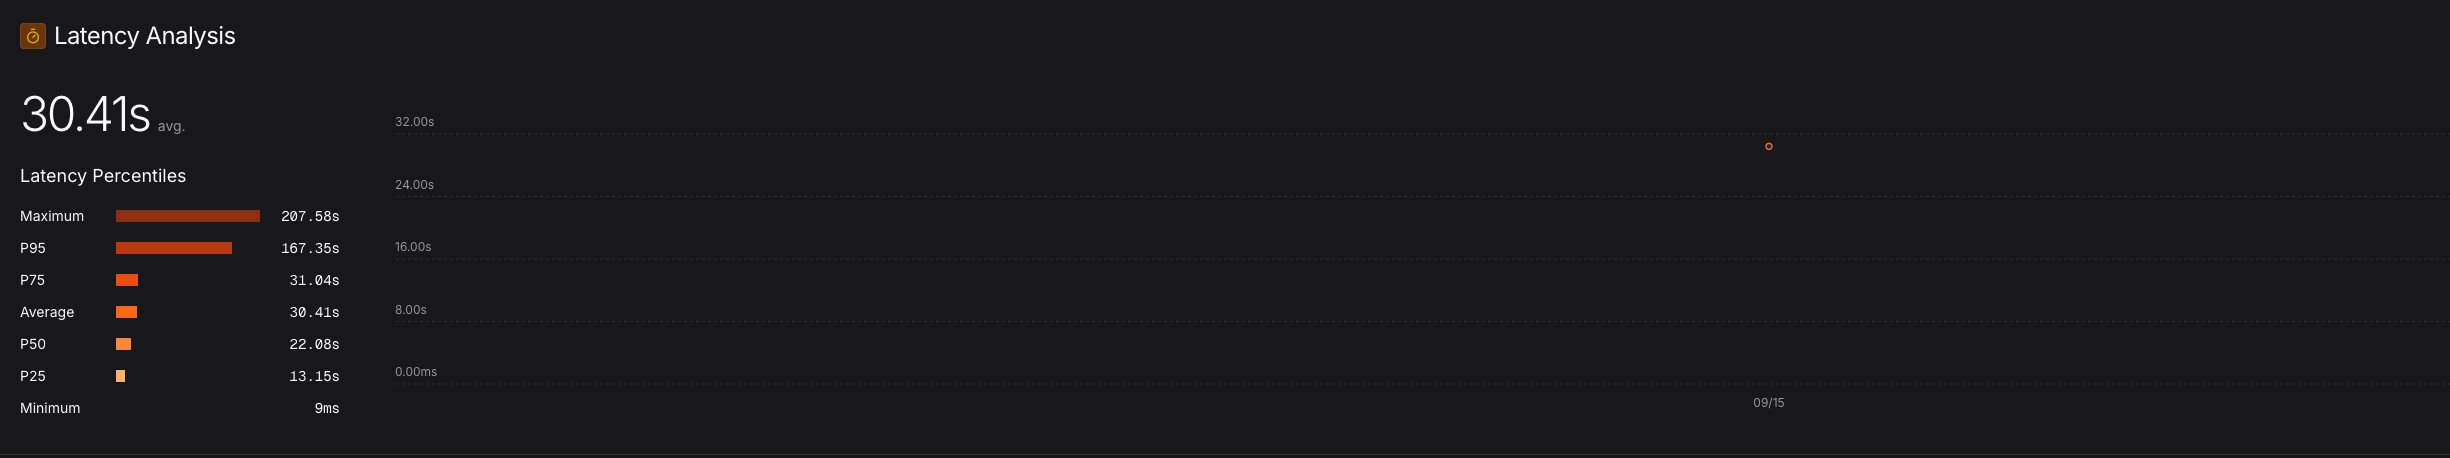

And there you go! It's that easy to create an RFT job from your existing agent code!


# Results

You can see the original task is quite tough for the agent and it isn't able to win any games

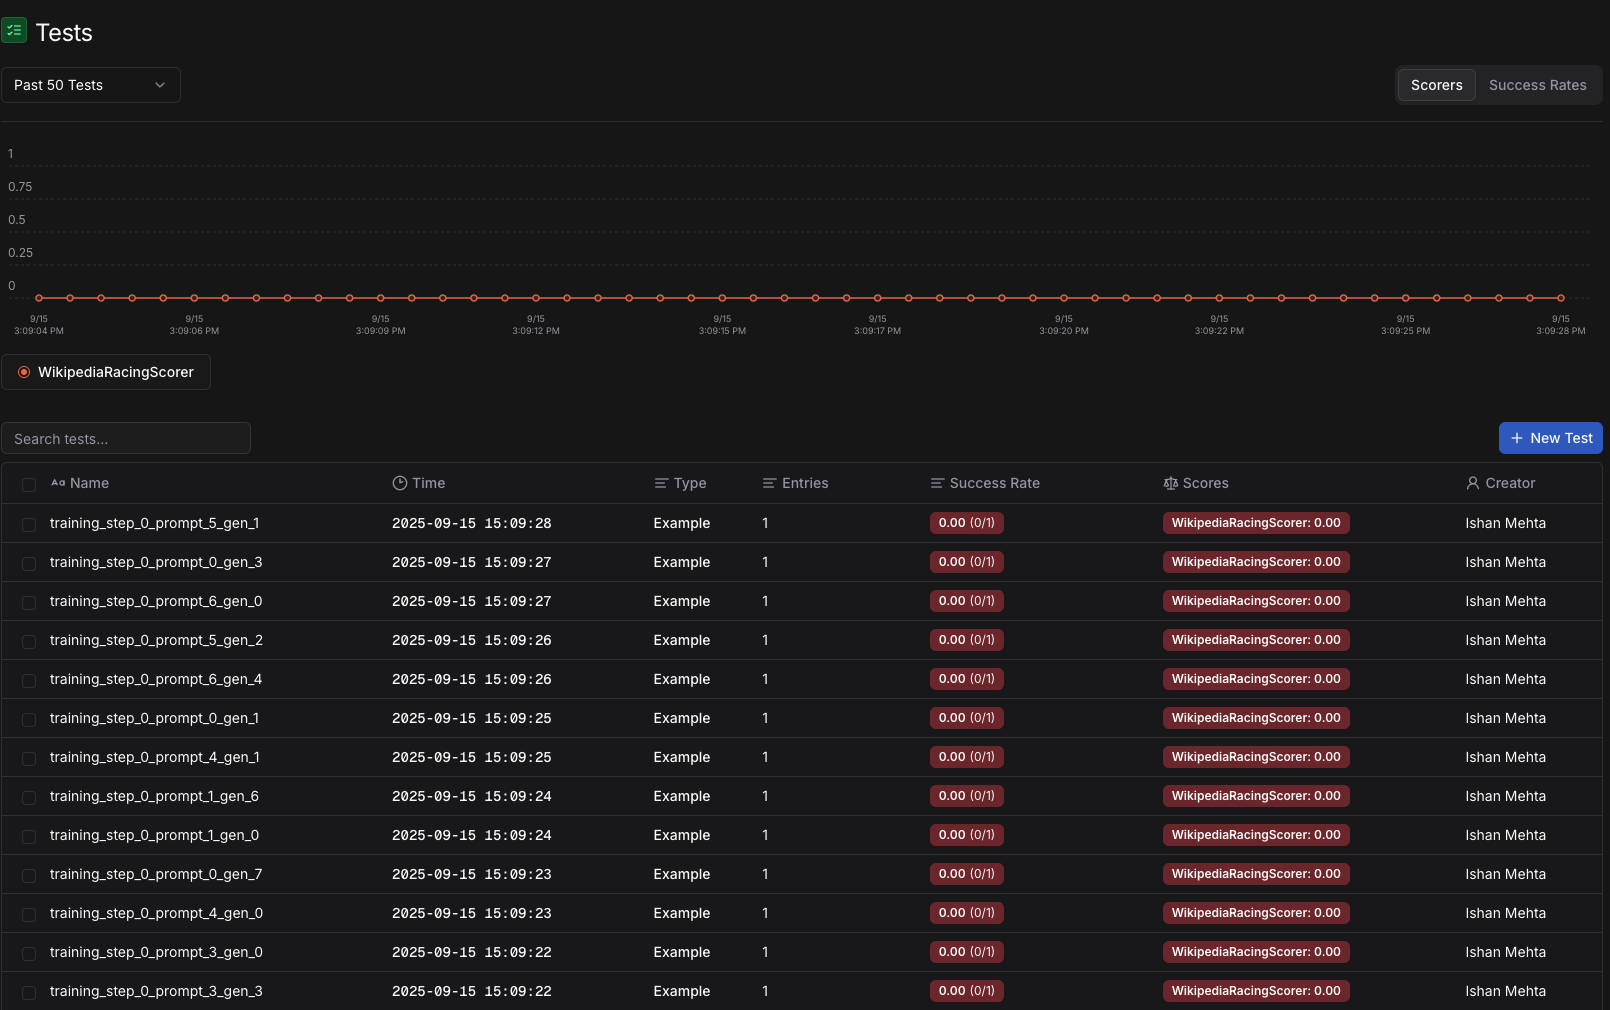

After some training, we can see a bit of improvement. This is when we began the RFT job. 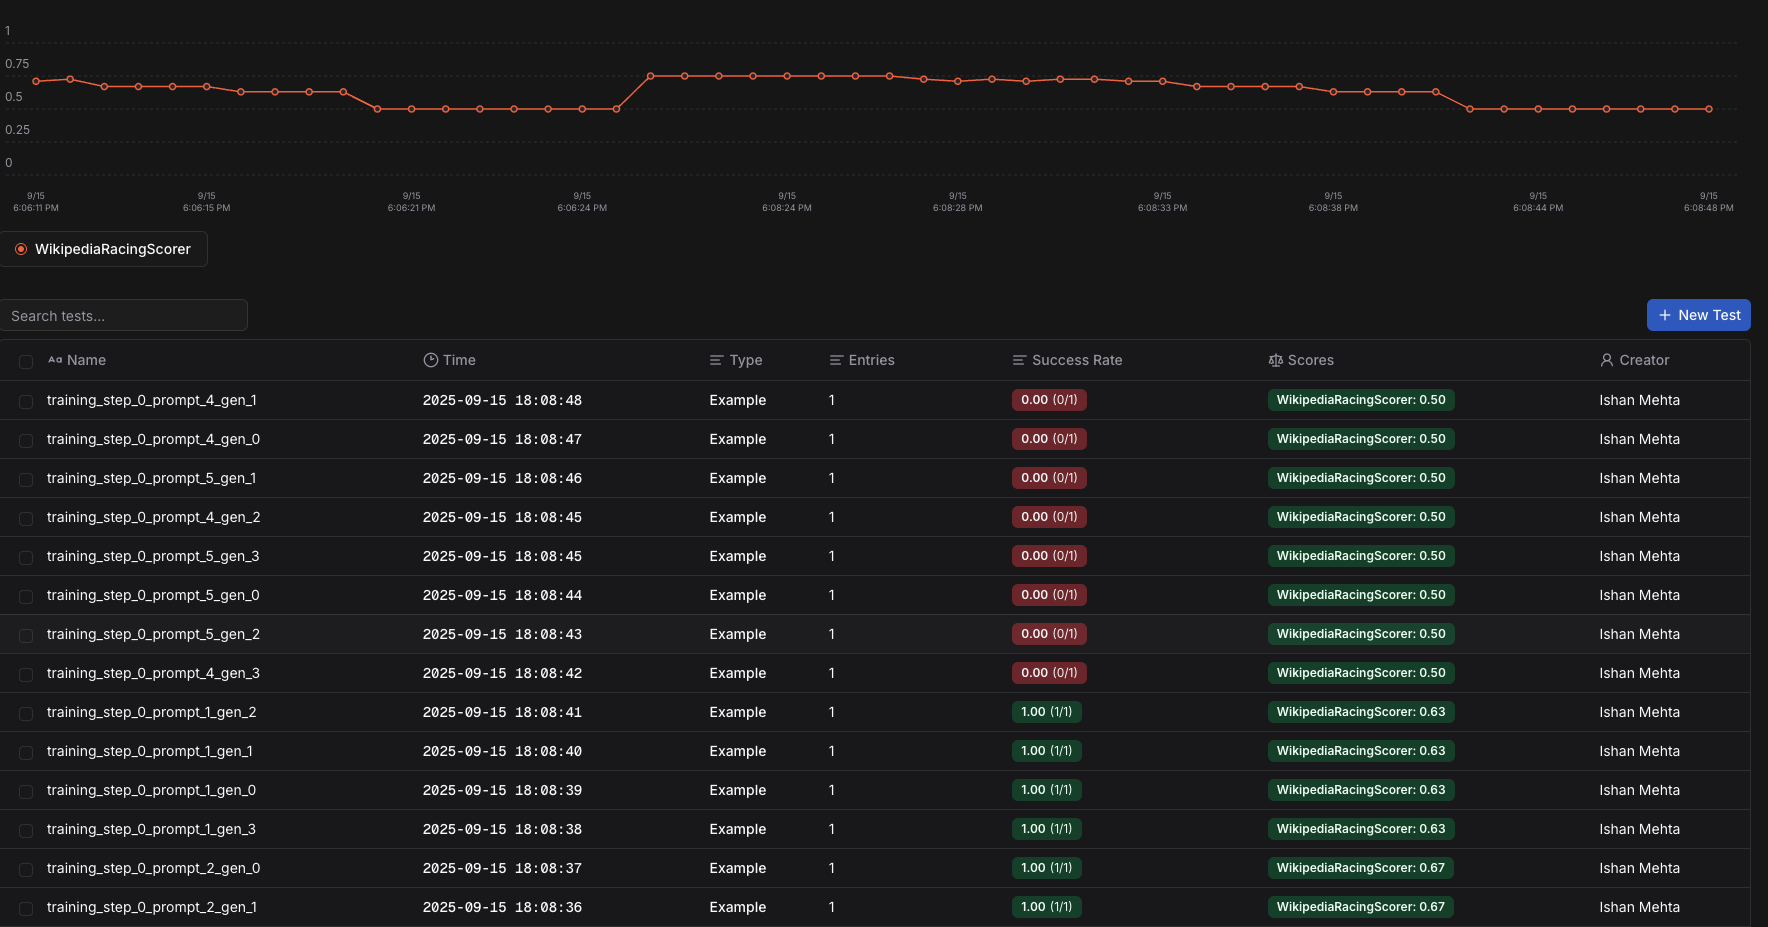

This is a bar-chart view from the Judgment UI that shows our intermediate progress. 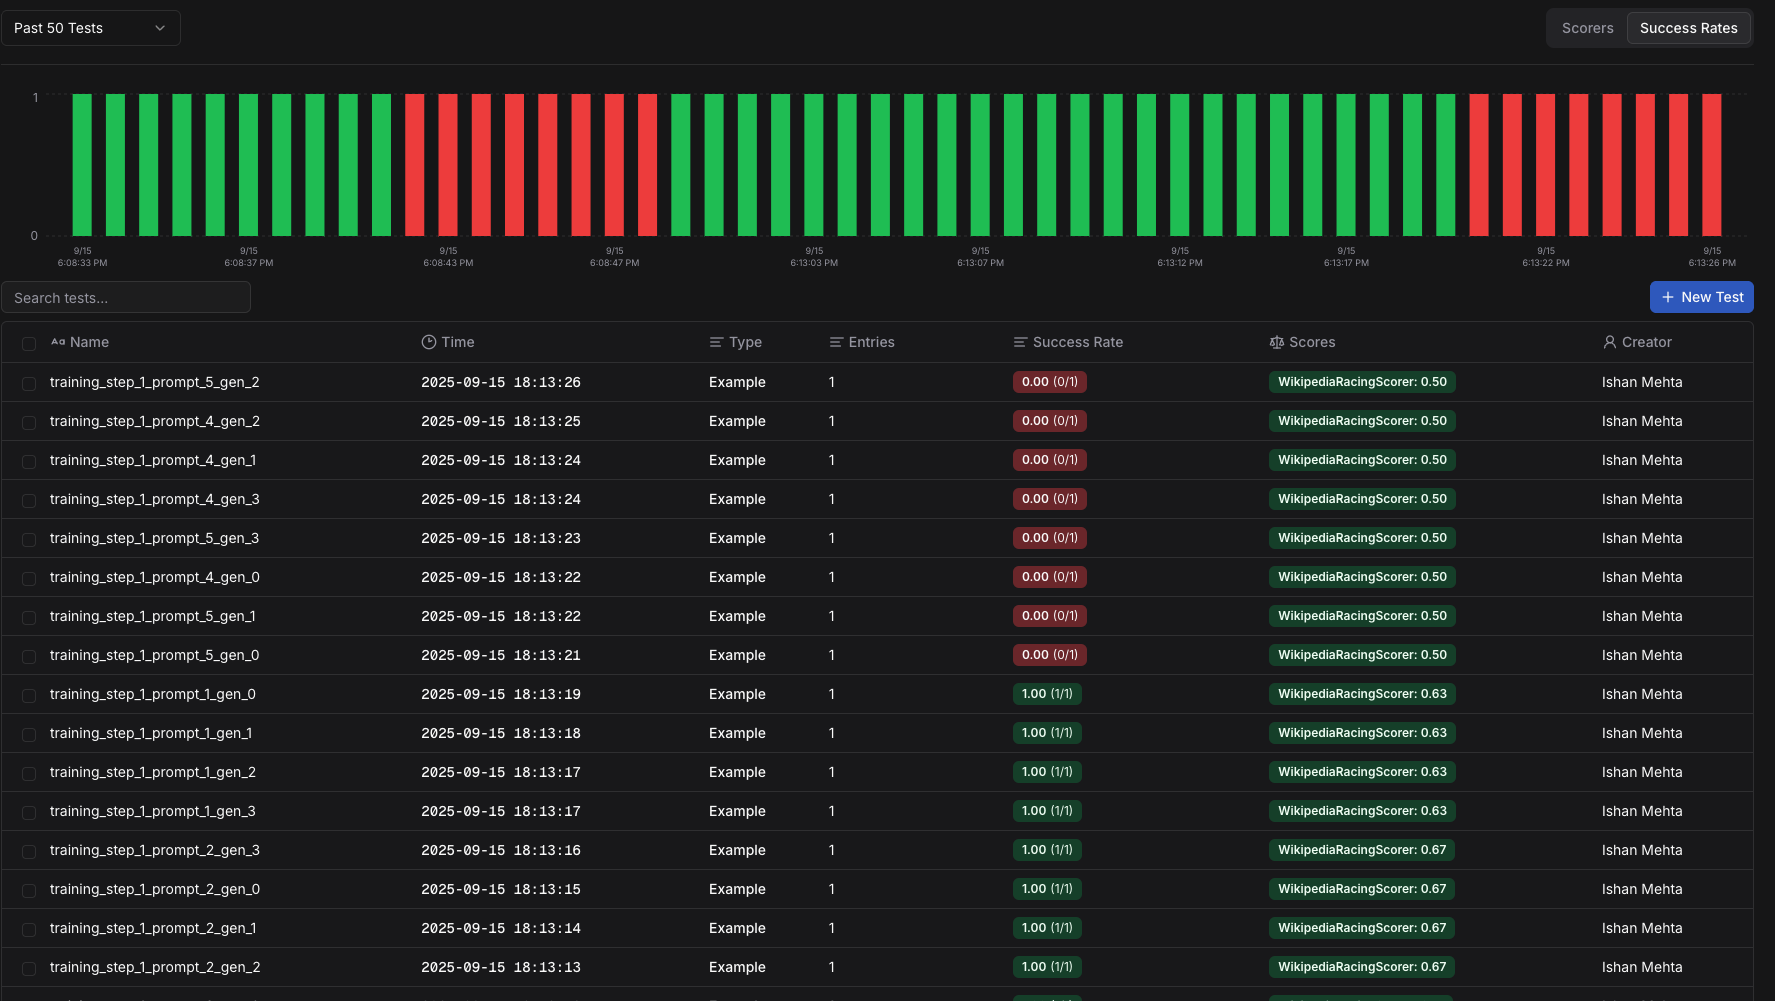

Now, we have our end result of the RFT job! 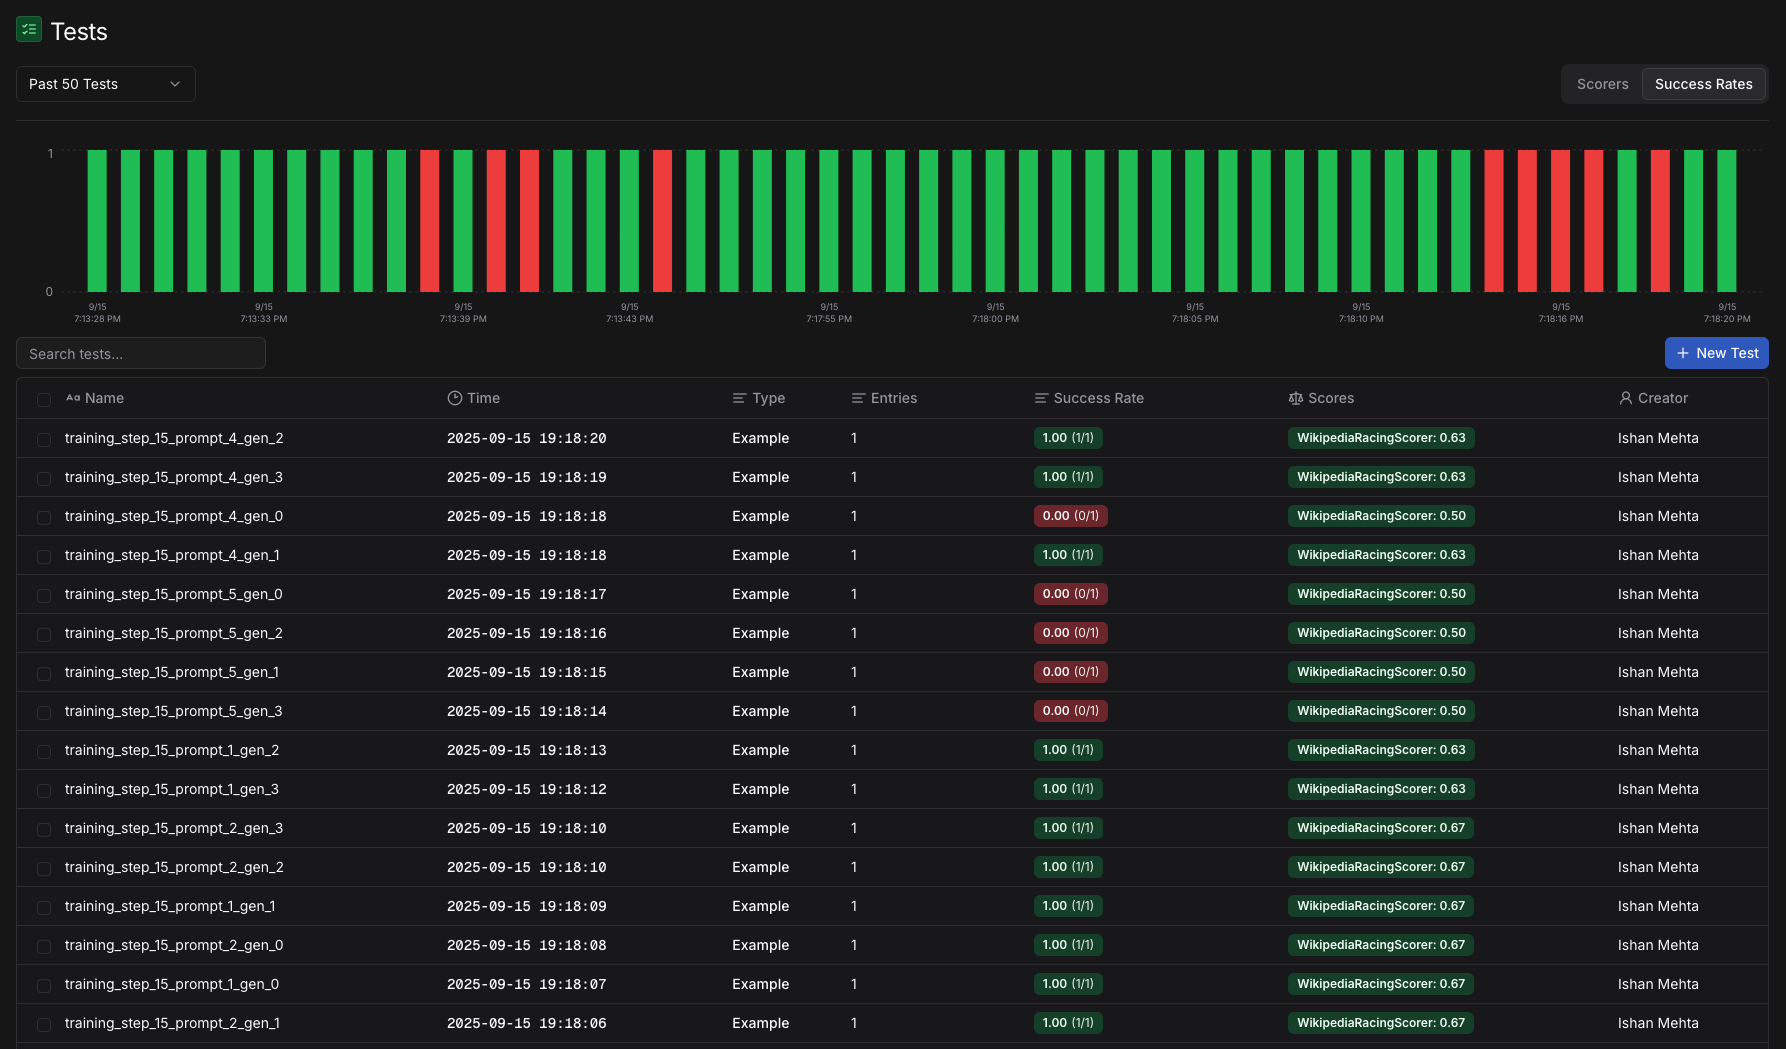

As you can see, there is an accuracy increase from 0% initially to approximately 68% at the beginning of the RFT job to 82% after the RFT!